In [1]:
%load_ext autoreload
%autoreload 2
from plot import *
import os
import sys

sys.path.append(os.path.abspath('../'))
from analysis_util import *

from norm import read_norm_data
from sgd_weights import sgd_weights

config=None
inputs=None
target=None
norm=None


In [2]:
# results_path = '../../results/bloat-then-min-prune/conditions/bloat-then-min-prune-64-0/run_18245290851331019246'
results_path = '../../results/bloat-prune/conditions/64-0/run_18245290851331019246'
# results_path = '../../results/bloat-prune/conditions/16-16/run_169547195123044846'
# results_path = '../../results/bloat-prune/conditions/64-64/run_1274002656662721006'

In [3]:
os.makedirs(os.path.join(results_path,'figures'), exist_ok=True)

In [4]:
genomes_by_batch, config = get_cppns_by_batch(results_path, 10)

FileNotFoundError: [Errno 2] No such file or directory: '../../results/bloat-prune/conditions/64-0/run_18245290851331019246/genomes'

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inputs = load_inputs(results_path, device)
target = load_target(results_path, config)
norm = read_norm_data(os.path.join("../", config.norm_df_path), config.target_name)
   
print(inputs.shape)

FileNotFoundError: [Errno 2] No such file or directory: '../../results/bloat-prune/conditions/64-0/run_18245290851331019246/inputs.pt'

In [ ]:
show_img_progression(genomes_by_batch, inputs, os.path.join(results_path,'progression.png'))

In [7]:
num_steps = 500
config.sgd_steps = num_steps

AttributeError: 'NoneType' object has no attribute 'sgd_steps'

In [8]:
import torch

def get_sgd_loss(cppn, config=config, inputs=inputs,target=target, norm=norm, num_steps=num_steps):
    losses = torch.zeros(num_steps)
    sgd_weights([cppn], None, inputs, target, config.objective_functions, norm, config, None, losses)
    return losses

In [ ]:
# all_losses_unmutated = torch.ones(len(genomes_by_batch), num_steps) * -torch.inf
# for index, (batch, cppn) in enumerate(genomes_by_batch.items()):
#     all_losses_unmutated[index] = get_sgd_loss(cppn)
        

In [ ]:
show_img_progression(genomes_by_batch, inputs, os.path.join(results_path,'figures/progression_sgd.png'))

NameError: name 'genomes_by_batch' is not defined

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_sgd_loss(losses, title, save_name):
    sns.set_style("darkgrid")
    sns.set_context("paper")
    sns.lineplot(data=losses.T, dashes=False, legend='full')
    # change legend to batch from index
    plt.legend(title='Batch')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.gca().legend(handles=handles, labels=list(genomes_by_batch.keys()), title='Batch')
    plt.xlabel('SGD step')
    plt.ylabel('Loss')
    plt.title(title)
    if save_name is not None:
        save_path = os.path.join(results_path, save_name)
        plt.savefig(save_path)
    plt.show()

import warnings
warnings.filterwarnings('ignore', 'FutureWarning: is_categorical_dtype is deprecated') # ignore warning about seaborn

In [ ]:
plot_sgd_loss(all_losses_unmutated, 'Inner loop loss (unmutated)', 'figures/sgd_loss_unmutated.png')

In [ ]:
# all_losses_mutated = torch.ones(len(genomes_by_batch), num_steps) * -torch.inf
# mutated_cppns = {}
# set_max_node_id(genomes_by_batch)
# muts = 10
# for index, (batch, cppn) in enumerate(genomes_by_batch.items()):
#     cppn_mutated = cppn.clone(config)
#     trials = []
#     for _ in range(muts):
#         cppn_mutated.mutate(config)
#         mutated_cppns[batch] = cppn_mutated
#         trials.append(get_sgd_loss(cppn_mutated))
#     all_losses_mutated[index] = torch.stack(trials).mean(dim=0)

In [10]:
show_img_progression(mutated_cppns, inputs, os.path.join(results_path,'figures/progression_mutated.png'))


NameError: name 'mutated_cppns' is not defined

In [ ]:
plot_sgd_loss(all_losses_mutated, 'Inner loop loss (avg. after mutation)' , 'figures/sgd_loss_mutated.png')

In [62]:
def run_one(run_path, cond_dir, device, modulo, num_steps):
    print(run_path, cond_dir)
    this_data =  pd.DataFrame(columns=['run', 'batch', 'loss'])
    try:
        genomes_by_batch, config = get_cppns_by_batch(run_path, modulo, always_include_last=True)
    except Exception as e:
        print(e)
        return pd.DataFrame()
    config.sgd_steps = num_steps
    if not os.path.exists(os.path.join(run_path, 'inputs.pt')):
        print('no inputs')
        return pd.DataFrame()
    inputs = load_inputs(run_path, device)
    target = load_target(run_path, config)
    norm = read_norm_data(os.path.join("../", config.norm_df_path), config.target_name)
    
    all_losses_unmutated = torch.ones(len(genomes_by_batch), num_steps) * -torch.inf
    batches = []
    for index, (batch, cppn) in enumerate(genomes_by_batch.items()):
        all_losses_unmutated[index] = get_sgd_loss(cppn, config, inputs,target, norm, num_steps)
        batches.append(batch)
    # include all steps
    for index, (batch, cppn) in enumerate(genomes_by_batch.items()):
        batch_name = batch
        if batch == max(genomes_by_batch.keys()):
            batch_name = 'last'
        elif batch == min(genomes_by_batch.keys()):
            batch_name = 'first'
        else:
            batch_name = 'mid'
            run_dir = os.path.basename(os.path.normpath(run_path))
            data = (pd.DataFrame({'run': run_dir, 'condition_path': cond_dir, 'target':config.target_name, 'batch': batch_name, 'step': torch.arange(num_steps), 'loss': all_losses_unmutated[index].cpu().numpy()}))
            this_data = pd.concat([this_data, data])
    return this_data

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import multiprocessing as mp
mp.set_start_method('spawn', force=True)
def full_experiment(experiment_path, num_steps=100, modulo=10):
    all_results = pd.DataFrame(columns=['run', 'batch', 'loss'])
    cond_path = os.path.join(experiment_path, 'conditions')
    # cond_dirs = [cond_dir for cond_dir in os.listdir(cond_path) if os.path.isdir(os.path.join(cond_path, cond_dir))]
    cond_dirs = ['000_steps_']
    run_paths = []
    for cond_dir in cond_dirs:
        run_paths += [os.path.join(cond_path, cond_dir, run_dir) for run_dir in os.listdir(os.path.join(cond_path, cond_dir)) if os.path.isdir(os.path.join(cond_path, cond_dir, run_dir))]
    
    jobs = [(run_path, cond_dir, device, modulo, num_steps) for cond_dir in cond_dirs for run_path in run_paths]
    print(len(jobs), 'jobs')
    print(jobs)
    
    pool = mp.Pool(mp.cpu_count()//2)
    mp_return = pool.starmap(run_one, jobs)
    
    
    all_results = pd.concat(mp_return)
    
    
    # for cond_dir in os.listdir(cond_path):
    #     if not os.path.isdir(os.path.join(cond_path, cond_dir)):
    #         continue
    #     for run_dir in os.listdir(os.path.join(cond_path, cond_dir)):
    #         print(run_dir)
    #         if not os.path.isdir(os.path.join(cond_path, cond_dir, run_dir)):
    #             continue
            
            
        
    return all_results

In [65]:
from tqdm import tqdm
results = full_experiment('../../results/sgd-steps', num_steps=100, modulo=10000)

49 jobs
[('../../results/sgd-steps/conditions/000_steps_/run_18401199831074804206', '000_steps_', device(type='cuda'), 10000, 100), ('../../results/sgd-steps/conditions/000_steps_/run_324821189710057966', '000_steps_', device(type='cuda'), 10000, 100), ('../../results/sgd-steps/conditions/000_steps_/run_146899162996150766', '000_steps_', device(type='cuda'), 10000, 100), ('../../results/sgd-steps/conditions/000_steps_/run_1220579775122379246', '000_steps_', device(type='cuda'), 10000, 100), ('../../results/sgd-steps/conditions/000_steps_/run_1233503383255519726', '000_steps_', device(type='cuda'), 10000, 100), ('../../results/sgd-steps/conditions/000_steps_/run_17422034561322258926', '000_steps_', device(type='cuda'), 10000, 100), ('../../results/sgd-steps/conditions/000_steps_/run_17431451749565141486', '000_steps_', device(type='cuda'), 10000, 100), ('../../results/sgd-steps/conditions/000_steps_/run_142726301620376046', '000_steps_', device(type='cuda'), 10000, 100), ('../../results

Process SpawnPoolWorker-403:
Process SpawnPoolWorker-396:
Process SpawnPoolWorker-404:
Process SpawnPoolWorker-393:
Process SpawnPoolWorker-392:
Process SpawnPoolWorker-391:
Process SpawnPoolWorker-401:
Process SpawnPoolWorker-407:
Process SpawnPoolWorker-389:
Process SpawnPoolWorker-390:
Process SpawnPoolWorker-395:
Process SpawnPoolWorker-400:
Process SpawnPoolWorker-398:
Process SpawnPoolWorker-399:
Process SpawnPoolWorker-387:
Process SpawnPoolWorker-405:
Process SpawnPoolWorker-406:
Process SpawnPoolWorker-397:
Process SpawnPoolWorker-408:
Traceback (most recent call last):
  File "/users/j/s/jsdean/scratch/bin/miniconda3/envs/move-amd/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/users/j/s/jsdean/scratch/bin/miniconda3/envs/move-amd/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/users/j/s/jsdean/scratch/bin/miniconda3/envs/move-amd/lib/python3.9/multiprocessing/pool.py

KeyboardInterrupt: 

In [61]:
print(results)

Empty DataFrame
Columns: []
Index: []


In [ ]:
results.to_csv('sgd-steps-inner-loop.csv')

/users/j/s/jsdean/scratch/bin/miniconda3/envs/move-amd/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/j/s/jsdean/scratch/bin/miniconda3/envs/move-amd/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/j/s/jsdean/scratch/bin/miniconda3/envs/move-amd/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/j/s/jsdean/scratch/bin/miniconda3/envs/move-amd/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: Fut

<Axes: xlabel='step', ylabel='loss'>

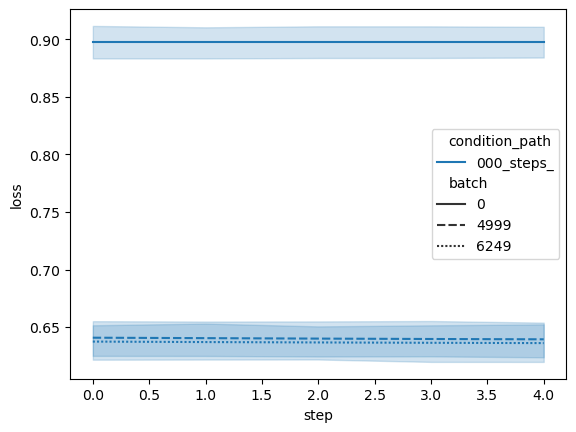

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=results, x='step', y='loss', hue='condition_path', legend='full', style='batch')

In [ ]:
print(results)

                         run batch      loss condition_path            target  \
0   run_18401199831074804206     0  0.941218     000_steps_  data/dolphin.png   
1   run_18401199831074804206     0  0.941218     000_steps_  data/dolphin.png   
2   run_18401199831074804206     0  0.941218     000_steps_  data/dolphin.png   
3   run_18401199831074804206     0  0.941218     000_steps_  data/dolphin.png   
4   run_18401199831074804206     0  0.941218     000_steps_  data/dolphin.png   
..                       ...   ...       ...            ...               ...   
0   run_17403682423764488686  6249  0.571967     000_steps_  data/sunrise.png   
1   run_17403682423764488686  6249  0.571721     000_steps_  data/sunrise.png   
2   run_17403682423764488686  6249  0.571492     000_steps_  data/sunrise.png   
3   run_17403682423764488686  6249  0.571298     000_steps_  data/sunrise.png   
4   run_17403682423764488686  6249  0.571114     000_steps_  data/sunrise.png   

    step  
0    0.0  
1    